## Problem Statement

We need to build a model that is able to classify Customer Complaints based on the products/services. By doing so you can segregate these tickets into their relevant categories. 

As data is not labeled, apply NMF to analyse patterns and classify the tickets into the following 5 clusters based on the products/services.

Credit Card/ Prepaid card

Bank Account Servises

Theft/Dispute Reporting

Mortgages/loans

Others

## Importing Libraries

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
import nltk
import string
import spacy
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [86]:
import warnings
warnings.filterwarnings("ignore")

## Loading data from JSON file

In [87]:
import json
fp = open("Client_data.json")
data = json.load(fp)
df = pd.json_normalize(data)
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Exploratory Data Analysis (EDA)

In [88]:
df.dtypes

_index                                object
_type                                 object
_id                                   object
_score                               float64
_source.tags                          object
_source.zip_code                      object
_source.complaint_id                  object
_source.issue                         object
_source.date_received                 object
_source.state                         object
_source.consumer_disputed             object
_source.product                       object
_source.company_response              object
_source.company                       object
_source.submitted_via                 object
_source.date_sent_to_company          object
_source.company_public_response       object
_source.sub_product                   object
_source.timely                        object
_source.complaint_what_happened       object
_source.sub_issue                     object
_source.consumer_consent_provided     object
dtype: obj

In [89]:
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [90]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [91]:
df = df.rename(columns = {'_source.complaint_what_happened':'complaint','_source.product':'category','_source.sub_product':'subcategory'})
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,subcategory,_source.timely,complaint,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [92]:
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', 'category',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       'subcategory', '_source.timely', 'complaint', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [93]:
# merge category and subcategory
df['category'] = df['category']+'+'+df['subcategory']

In [94]:
df=df.drop(['subcategory'],axis= 1)

In [95]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,category,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.timely,complaint,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Debt collection+Credit card debt,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Debt collection+Credit card debt,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Credit card or prepaid card+General-purpose cr...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Mortgage+Conventional home mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Credit card or prepaid card+General-purpose cr...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,Yes,,Charged too much interest,N/A


In [96]:
# Checking NULL values
df['complaint'].isnull().sum()

0

In [97]:
# Checking empty strings
len(df[df['complaint'] == ''])

57241

In [98]:
# Assign NAN in place of empty strins
df[df['complaint']==''] = np.nan

In [99]:
df['complaint'].isnull().sum()

57241

In [100]:
# Delete all rows having NAN in complaint column
df=df[~df['complaint'].isnull()]

In [101]:
df['complaint'].isnull().sum()

0

## Preparing text for topic modeling

In [102]:
def text_clean(review):
    review = re.sub('\[.*\]','',review).strip() # remove text in square brackets
    review = review.lower() # make the text in lower case
    review = re.sub('\S*\d\S*\s*','',review).strip() # remove words containing numbers
    review = review.translate(str.maketrans('','',string.punctuation)) # remove punctuation
    return review.strip()

In [103]:
df['complaint'] = df['complaint'].apply(lambda x:text_clean(x))
df['complaint'].head()

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in and was told b...
10    chase card was reported on however fraudulent ...
11    on while trying to book a xxxx  xxxx  ticket i...
14    my grand son give me check for i deposit it in...
Name: complaint, dtype: object

In [104]:
# Lemmatization

nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words

def lemmatizer(text):
    review = nlp(text)
    text1 = [token.lemma_ for token in review if not token.text in set(stopwords)]
    return ' '.join(text1)
df['lemma'] = df['complaint'].apply(lambda x:lemmatizer(x))
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.timely,complaint,_source.sub_issue,_source.consumer_consent_provided,lemma
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning xxxx xxxx appreciate help stop ch...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,Yes,i upgraded my xxxx xxxx card in and was told b...,Problem with rewards from credit card,Consent provided,upgrade xxxx xxxx card tell agent upgrade anni...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Yes,chase card was reported on however fraudulent ...,Information belongs to someone else,Consent provided,chase card report fraudulent application submi...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Yes,on while trying to book a xxxx xxxx ticket i...,Information belongs to someone else,Consent provided,try book xxxx xxxx ticket come offer apply...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Yes,my grand son give me check for i deposit it in...,Funds not handled or disbursed as instructed,Consent provided,grand son check deposit chase account fund cle...


In [105]:
df['lemma']

1        good morning xxxx xxxx appreciate help stop ch...
2        upgrade xxxx xxxx card tell agent upgrade anni...
10       chase card report fraudulent application submi...
11       try book xxxx   xxxx   ticket come offer apply...
14       grand son check deposit chase account fund cle...
                               ...                        
78303    chase card customer decade offer multiple soli...
78309    wednesday xxxxxxxx call chas xxxx xxxx visa cr...
78310    familiar xxxx pay understand great risk provid...
78311    flawless credit yrs ve chase credit card   cha...
78312    roughly year ago close account jp morgan chase...
Name: lemma, Length: 21072, dtype: object

In [106]:
# Create a new dataframe contains only complaints and lemma
df_new = df[['complaint','lemma','category']]
df_new.head()

,complaint,lemma,category
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o..."
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o..."
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account


In [107]:
# function for POS
def extract_pos(text):
    review = nlp(text)
    text1 = [token.text for token in review if token.tag_ == 'NN']
    return ' '.join(text1)

In [108]:
df_new['complaint_pos_removed'] = df_new.lemma.apply(lambda x: extract_pos(x))
df_new.head()

,complaint,lemma,category,complaint_pos_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help write chase debt verification sta...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,agent upgrade anniversary date change agent in...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o...",book ticket ticket reward card information off...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,son deposit chase account account pay money sp...


In [109]:
# remove xxxx of customer personal details
df_new['complaint'] = df_new['complaint'].str.replace('xxxx','')
df_new.head()

,complaint,lemma,category,complaint_pos_removed
1,good morning my name is and i appreciate it ...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help write chase debt verification sta...
2,i upgraded my card in and was told by the ag...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,agent upgrade anniversary date change agent in...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...
11,on while trying to book a ticket i came ac...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o...",book ticket ticket reward card information off...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,son deposit chase account account pay money sp...


## Feature Extraction

In [110]:
# convert raw texts to matrix of TF-IDF
cv = TfidfVectorizer(min_df=2,max_df=0.95,stop_words='english')

In [111]:
dtm = cv.fit_transform(df_new.complaint)

In [112]:
cv.get_feature_names()[:10]

['aa',
 'aaaratings',
 'aarp',
 'ab',
 'aba',
 'aback',
 'abandon',
 'abandoned',
 'abandonment',
 'abate']

In [113]:
len(cv.get_feature_names())

15706

## Topic Modelling using NMF

In [114]:
from sklearn.decomposition import NMF

In [115]:
number_of_topics = 5
nmf_model = NMF(n_components=number_of_topics,random_state=40)
w1 = nmf_model.fit_transform(dtm)
h1 = nmf_model.components_

In [116]:
colnames = ["Topic" +str(i) for i in range(nmf_model.n_components)]
docnames = ["Doc" +str(i) for i in range(len(df_new.complaint))]
df_doc_topic = pd.DataFrame(np.round(w1,2),columns=colnames,index=docnames)
significant_topic = np.argmax(df_doc_topic.values,axis=1)
df_doc_topic['dominant_topic'] = significant_topic
df_doc_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.01,0.01,0.03,0.02,0.01,2
Doc1,0.01,0.01,0.00,0.01,0.00,0
Doc2,0.01,0.04,0.00,0.00,0.00,1
Doc3,0.02,0.05,0.02,0.02,0.00,1
Doc4,0.00,0.00,0.00,0.07,0.00,3


In [117]:
df_new['Topic'] = significant_topic

In [118]:
df_new

,complaint,lemma,category,complaint_pos_removed,Topic
1,good morning my name is and i appreciate it ...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help write chase debt verification sta...,2
2,i upgraded my card in and was told by the ag...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,agent upgrade anniversary date change agent in...,0
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...,1
11,on while trying to book a ticket i came ac...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o...",book ticket ticket reward card information off...,1
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,son deposit chase account account pay money sp...,3
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,Credit card or prepaid card+General-purpose cr...,chase card customer decade solicitation credit...,1
78309,on wednesday i called chas my visa credit c...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,Credit card or prepaid card+General-purpose cr...,credit card provider ask claim purchase protec...,0
78310,i am not familiar with pay and did not unders...,familiar xxxx pay understand great risk provid...,Checking or savings account+Checking account,pay risk consumer app chase year trust banking...,0
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,Credit card or prepaid card+General-purpose cr...,credit chase credit card chase freedom problem...,4


In [119]:
topics = { 0: 'Banking services', 1:'Credit Card / Prepaid Card', 2:'Others', 3:'Theft/Dispute Reporting', 4:'Mortgage/Loan'}
df_new['Topic'] = df_new['Topic'].map(topics)

In [120]:
df_new.head()

,complaint,lemma,category,complaint_pos_removed,Topic
1,good morning my name is and i appreciate it ...,good morning xxxx xxxx appreciate help stop ch...,Debt collection+Credit card debt,morning help write chase debt verification sta...,Others
2,i upgraded my card in and was told by the ag...,upgrade xxxx xxxx card tell agent upgrade anni...,Credit card or prepaid card+General-purpose cr...,agent upgrade anniversary date change agent in...,Banking services
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,"Credit reporting, credit repair services, or o...",chase card report application submit identity ...,Credit Card / Prepaid Card
11,on while trying to book a ticket i came ac...,try book xxxx xxxx ticket come offer apply...,"Credit reporting, credit repair services, or o...",book ticket ticket reward card information off...,Credit Card / Prepaid Card
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,Checking or savings account+Checking account,son deposit chase account account pay money sp...,Theft/Dispute Reporting


<AxesSubplot:xlabel='Topic', ylabel='count'>

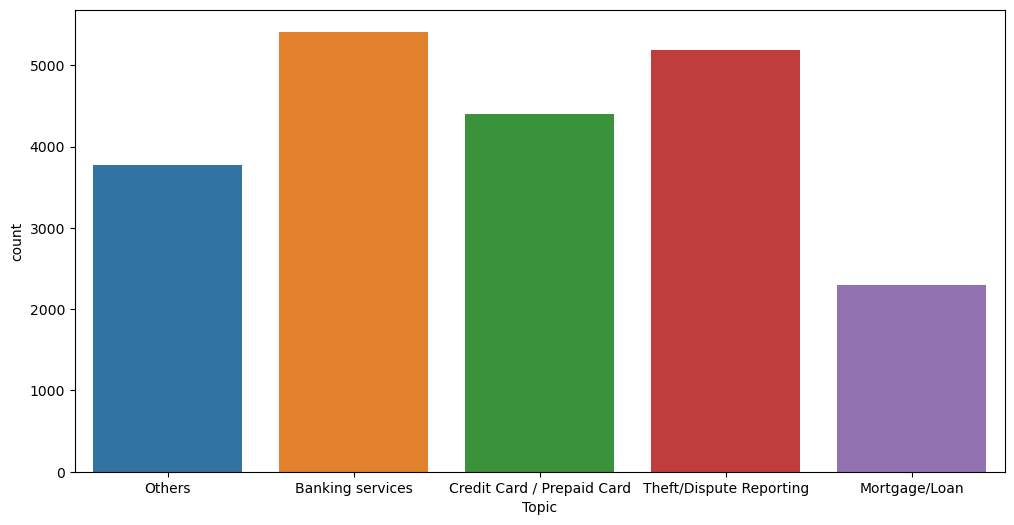

In [121]:
plt.figure(figsize=(12,6))
sns.countplot(x ='Topic',data= df_new)

In [122]:
training_data = df_new[['complaint','Topic']]

In [123]:
training_data.head()

,complaint,Topic
1,good morning my name is and i appreciate it ...,Others
2,i upgraded my card in and was told by the ag...,Banking services
10,chase card was reported on however fraudulent ...,Credit Card / Prepaid Card
11,on while trying to book a ticket i came ac...,Credit Card / Prepaid Card
14,my grand son give me check for i deposit it in...,Theft/Dispute Reporting


In [124]:
# reverse topic names mapping for supervised learning
rev_topic_mapping = {'Banking services':0, 'Credit Card / Prepaid Card':1, 'Others':2, 'Theft/Dispute Reporting':3, 'Mortgage/Loan':4}
training_data['Topic'] = training_data['Topic'].map(rev_topic_mapping)
training_data.head()

,complaint,Topic
1,good morning my name is and i appreciate it ...,2
2,i upgraded my card in and was told by the ag...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a ticket i came ac...,1
14,my grand son give me check for i deposit it in...,3


In [125]:
# X-y split
X = training_data['complaint']
y = training_data['Topic']

In [126]:
# get vector count
count_vec = CountVectorizer()
X_vect = count_vec.fit_transform(X)

In [127]:
# fit transform word vector to TF-IDF
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_vect)

In [128]:
# train test split
X_train,X_test,y_train,y_test = train_test_split(X_tfidf,y,test_size=0.25,random_state=40)

In [133]:
# Model classification report
def classification_report_disp(model,metric):
    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    roc_score_train = round(roc_auc_score(y_train, y_train_pred_proba,average='weighted',multi_class='ovr'),2)
    roc_score_test = round(roc_auc_score(y_test,y_test_pred_proba,average='weighted',multi_class='ovr'),2)
    print("ROC Auc Score Train = ",roc_score_train)
    print("ROC Auc Score Test = ",roc_score_test)
    metric.append(roc_score_train)
    metric.append(roc_score_test)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    precision_train,recall_train,f_score_train,support_train = precision_recall_fscore_support(y_train,y_train_pred,average='weighted')
    precision_test,recall_test,f_score_test,support_test = precision_recall_fscore_support(y_test,y_test_pred,average='weighted')
    acc_score_train = round(accuracy_score(y_train,y_train_pred),2)
    acc_score_test = round(accuracy_score(y_test,y_test_pred),2)
    metric.append(acc_score_train)
    metric.append(acc_score_test)
    metric.append(precision_train)
    metric.append(precision_test)
    metric.append(recall_train)
    metric.append(recall_test)
    metric.append(f_score_train)
    metric.append(f_score_test)
    
    print('Train Accuracy = ',acc_score_train)
    print('Test Accuracy = ',acc_score_test)
    
    model_report_train = classification_report(y_train,y_train_pred)
    model_report_test = classification_report(y_test,y_test_pred)
    print('Classification Report for Train = ',model_report_train)
    print('Classification Report for Test = ',model_report_test)
    
    cfm = confusion_matrix(y_test,y_test_pred)
    cmd = ConfusionMatrixDisplay(cfm,display_labels=model.classes_)
    cmd.plot()
    plt.xticks(rotation=80)
    plt.show()

## Logistic Regression Classification

ROC Auc Score Train =  1.0
ROC Auc Score Test =  1.0
Train Accuracy =  0.97
Test Accuracy =  0.94
Classification Report for Train =                precision    recall  f1-score   support

           0       0.96      0.98      0.97      4065
           1       0.98      0.97      0.98      3306
           2       0.99      0.97      0.98      2836
           3       0.96      0.99      0.98      3890
           4       0.98      0.93      0.95      1707

    accuracy                           0.97     15804
   macro avg       0.97      0.97      0.97     15804
weighted avg       0.97      0.97      0.97     15804

Classification Report for Test =                precision    recall  f1-score   support

           0       0.90      0.96      0.93      1347
           1       0.95      0.94      0.94      1088
           2       0.97      0.91      0.94       942
           3       0.93      0.96      0.95      1302
           4       0.96      0.87      0.92       589

    accuracy      

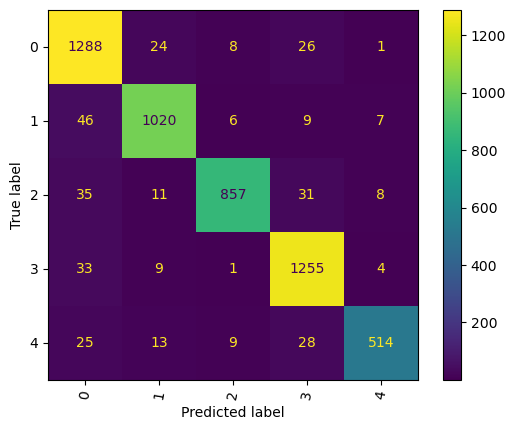

In [134]:
logreg = LogisticRegression(random_state= 40,solver='liblinear')
logreg.fit(X_train,y_train)
metric1 = []
classification_report_disp(logreg,metric1)

## Decision Tree Classifier

ROC Auc Score Train =  1.0
ROC Auc Score Test =  0.85
Train Accuracy =  1.0
Test Accuracy =  0.77
Classification Report for Train =                precision    recall  f1-score   support

           0       1.00      1.00      1.00      4065
           1       1.00      1.00      1.00      3306
           2       1.00      1.00      1.00      2836
           3       1.00      1.00      1.00      3890
           4       1.00      1.00      1.00      1707

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Classification Report for Test =                precision    recall  f1-score   support

           0       0.73      0.75      0.74      1347
           1       0.76      0.79      0.77      1088
           2       0.83      0.80      0.81       942
           3       0.81      0.78      0.80      1302
           4       0.69      0.68      0.69       589

    accuracy      

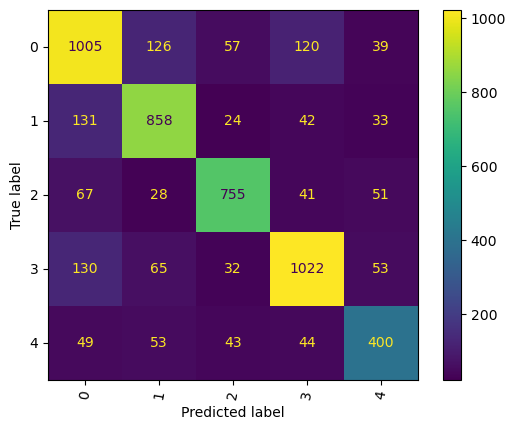

In [135]:
dtc = DecisionTreeClassifier(random_state=40)
dtc.fit(X_train,y_train)
metric2 = []
classification_report_disp(dtc,metric2)

## Random Forest Classification

ROC Auc Score Train =  1.0
ROC Auc Score Test =  0.98
Train Accuracy =  1.0
Test Accuracy =  0.83
Classification Report for Train =                precision    recall  f1-score   support

           0       1.00      1.00      1.00      4065
           1       1.00      1.00      1.00      3306
           2       1.00      1.00      1.00      2836
           3       1.00      1.00      1.00      3890
           4       1.00      1.00      1.00      1707

    accuracy                           1.00     15804
   macro avg       1.00      1.00      1.00     15804
weighted avg       1.00      1.00      1.00     15804

Classification Report for Test =                precision    recall  f1-score   support

           0       0.79      0.88      0.83      1347
           1       0.84      0.83      0.84      1088
           2       0.90      0.86      0.88       942
           3       0.82      0.92      0.87      1302
           4       0.93      0.50      0.65       589

    accuracy      

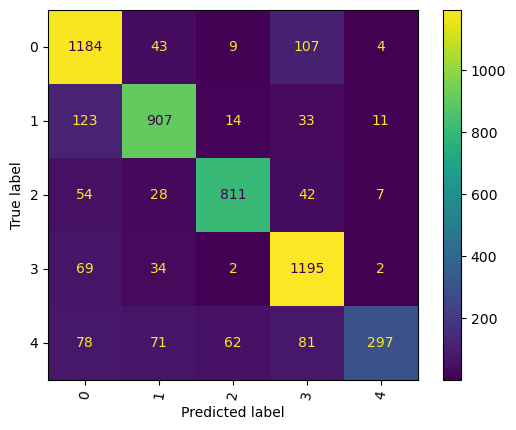

In [136]:
random_forest_classifier = RandomForestClassifier(random_state=40)
random_forest_classifier.fit(X_train,y_train)
metric3 = []
classification_report_disp(random_forest_classifier,metric3)


In [137]:
folds=StratifiedGroupKFold(n_splits=5,shuffle=True,random_state=40)
def grid_search(model,folds,params,scoring):
    grid_search = GridSearchCV(model,cv=folds,param_grid=params, scoring=scoring,n_jobs=-1,verbose=1)
    return grid_search

## Hyper parameter tunning 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
ROC Auc Score Train =  0.91
ROC Auc Score Test =  0.91
Train Accuracy =  0.68
Test Accuracy =  0.67
Classification Report for Train =                precision    recall  f1-score   support

           0       0.51      0.76      0.61      4065
           1       0.76      0.75      0.75      3306
           2       0.94      0.51      0.66      2836
           3       0.72      0.81      0.76      3890
           4       0.95      0.31      0.47      1707

    accuracy                           0.68     15804
   macro avg       0.78      0.63      0.65     15804
weighted avg       0.74      0.68      0.67     15804

Classification Report for Test =                precision    recall  f1-score   support

           0       0.51      0.76      0.61      1347
           1       0.76      0.75      0.75      1088
           2       0.94      0.50      0.65       942
           3       0.71      0.80      0.75      1302
          

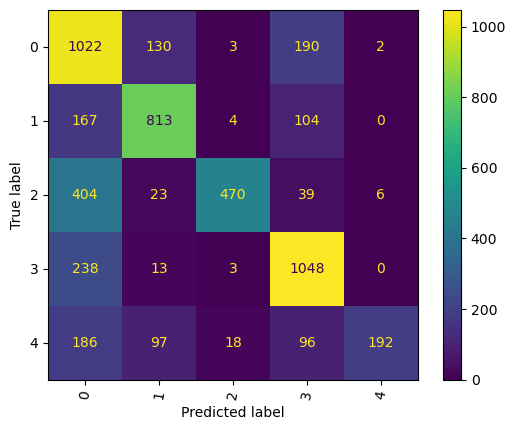

In [138]:
# Logistic Regression with GridSearchCV
log_reg = LogisticRegression()
log_params = {'C':[0.01,1,10],'penalty':['l1','l2'],'solver':['liblinear','newton-cg','saga']}
grid_search_log = grid_search(log_reg,folds,log_params,scoring=None)
grid_search_log.fit(X_train,y_train)
metric4 = []
classification_report_disp(grid_search_log,metric4)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
ROC Auc Score Train =  0.89
ROC Auc Score Test =  0.89
Train Accuracy =  0.7
Test Accuracy =  0.69
Classification Report for Train =                precision    recall  f1-score   support

           0       0.54      0.81      0.65      4065
           1       0.82      0.76      0.79      3306
           2       0.88      0.74      0.80      2836
           3       0.74      0.64      0.69      3890
           4       0.82      0.42      0.56      1707

    accuracy                           0.70     15804
   macro avg       0.76      0.67      0.70     15804
weighted avg       0.74      0.70      0.71     15804

Classification Report for Test =                precision    recall  f1-score   support

           0       0.53      0.78      0.63      1347
           1       0.80      0.75      0.77      1088
           2       0.86      0.73      0.79       942
           3       0.73      0.65      0.69      1302
           

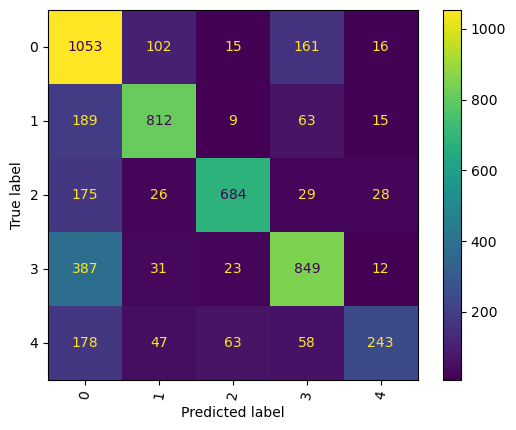

In [139]:
# Decision tree classification with GridSearchCV
dtc = DecisionTreeClassifier(random_state=40)
dtc_params = { 'max_depth' : [5,10,20,30], 'min_samples_leaf' : [5,10,20,30]}
dtc_grid_search = grid_search(dtc,folds,dtc_params,scoring='roc_auc_ovr')
dtc_grid_search.fit(X_train,y_train)
metric5 = []
classification_report_disp(dtc_grid_search,metric5)

## The best model looks to be Logistic Regression Classification